In [181]:
import polars as pl
import builtins
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [182]:
import plotly.io as pio
pio.renderers.default = "png" 

In [183]:
import plotly.express as px

In [184]:
path = r"C:\Users\Rudra\Desktop\bihar-viz\data\BL05.parquet"

# Load the Data

In [185]:
def load_level_05_data(path):
    # Load the data
    df = pl.read_parquet(path)
    
    # Correct datatype
    df = df.with_columns(
            (pl.col("OutOfHome_Consumption_Quantity").cast(pl.Float64, strict=False)),
            (pl.col("OutOfHome_Consumption_Value").cast(pl.Float64, strict=False))
        )
    
    # Select useful columns only
    df = df.select([
        'FSU_Serial_No','Sector','NSS_Region','District','Stratum',
        'Sub_stratum','Panel','Sub_sample','FOD_Sub_Region',
        'Sample_SU_No','Sample_Household_No','Questionnaire_No',
        'Item_Code','OutOfHome_Consumption_Quantity','OutOfHome_Consumption_Value',
        'Total_Consumption_Quantity','Total_Consumption_Value'
    ])
    
    return df

In [186]:
df = load_level_05_data(path)
fdf = df.clone()

In [187]:
fdf.head(2)

FSU_Serial_No,Sector,NSS_Region,District,Stratum,Sub_stratum,Panel,Sub_sample,FOD_Sub_Region,Sample_SU_No,Sample_Household_No,Questionnaire_No,Item_Code,OutOfHome_Consumption_Quantity,OutOfHome_Consumption_Value,Total_Consumption_Quantity,Total_Consumption_Value
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,i64,f64,f64,f64,i64
27865,2,101,14,12,2,5,1,1010,1,15,false,141,null,null,1.0,84
27865,2,101,14,12,2,5,1,1010,1,15,false,143,null,null,1.5,180


In [188]:
def category_mapping():
    return {
        129: "cereals",
        139: "cereal substitute",
        159: "pulses & products",
        179: "salt & sugar",
        169: "milk & milk products",
        219: "vegetables",
        239: "fruits (fresh)",
        249: "fruits (dry)",
        199: "egg, fish & meat",
        189: "edible oil",
        269: "spices",
        279: "beverages",
        289: "served processed food",
        299: "packaged processed food"
    }

In [189]:
def cereal_mapping():
    return {
        61: "rice-free",
        62: "wheat/atta-free",
        70: "coarse grains-free",
        101: "rice – PDS",
        102: "rice – other sources",
        103: "chira",
        105: "muri",
        106: "other rice products (khoi/lawa, etc.)",
        107: "wheat/atta – PDS",
        108: "wheat/atta – other sources",
        110: "maida",
        111: "suji/rawa",
        112: "vermicelli (sewai)",
        114: "other wheat products",
        1: "coarse grains – PDS",
        2: "coarse grains – other sources",
        122: "other cereals & products",
        129: "cereals: sub-total"
    }

# Category Load and Clean

In [190]:
def category_dict_to_dataframe(category_mapping:dict, fdf=fdf):
    """
    1. Create the dataframe form the dict
    2. Join with the original / Filter dataset
    3. Create totally new dataset for further analysis
        a. Only valid data 
        b. Then category, Out of Home and Total columns selected
        c. Aggregate the columns
        d. Provide a clean and valid dataset for further analysis.
    """
     
    # Create the dataframe form dictionary
    map_df = pl.DataFrame({
        "Item_Code": builtins.list(category_mapping.keys()),
        "category_mapped": builtins.list(category_mapping.values()),
    })

    # Join the category dataframe & whole dataset
    fdf = fdf.join(map_df, on="Item_Code", how="left")
    
    # Create a totally new dataframe with desire columns
    cat_df = fdf.filter(
        pl.col("category_mapped").is_not_null()
        ) \
        [
        'OutOfHome_Consumption_Quantity',
        'OutOfHome_Consumption_Value',
        'Total_Consumption_Quantity',
        'Total_Consumption_Value',
        "category_mapped"
        ] \
        .group_by("category_mapped").agg(
            pl.col("OutOfHome_Consumption_Value").sum().alias("out_home_value"),
            pl.col("OutOfHome_Consumption_Quantity").sum().alias("out_home_qty"),
            pl.col("Total_Consumption_Quantity").sum().alias("total_qty"),
            pl.col("Total_Consumption_Value").sum().alias("total_value")
        ).with_columns(
            out_of_home_avg_pice = pl.when(pl.col("out_home_qty") > 0) 
                            .then(pl.col("out_home_value") / pl.col("out_home_qty"))
                            .otherwise(0),
            total_avg_pice = pl.when(pl.col("total_qty") > 0) 
                            .then(pl.col("total_value") / pl.col("total_qty"))
                            .otherwise(0),
        ) 
        
    return cat_df

In [191]:
cat_df = category_dict_to_dataframe(cereal_mapping())


In [192]:
cat_df

category_mapped,out_home_value,out_home_qty,total_qty,total_value,out_of_home_avg_pice,total_avg_pice
str,f64,f64,f64,i64,f64,f64
"""suji/rawa""",0.0,0.0,5294.788,235353,0.0,44.449938
"""rice – PDS""",0.0,0.0,6656.0,23457,0.0,3.524189
"""vermicelli (sewai)""",0.0,0.0,1629.262,177745,0.0,109.095406
"""rice-free""",0.0,0.0,202578.008,0,0.0,0.0
"""coarse grains – other sources""",13112.0,607.5,2026.9,49226,21.583539,24.286349
…,…,…,…,…,…,…
"""wheat/atta-free""",0.0,0.0,50071.0,0,0.0,0.0
"""maida""",0.0,0.0,5662.765,224121,0.0,39.578015
"""wheat/atta – other sources""",2.381525e6,82514.0,358457.75,10850360,28.862072,30.269565


In [193]:
cat_df.columns

['category_mapped',
 'out_home_value',
 'out_home_qty',
 'total_qty',
 'total_value',
 'out_of_home_avg_pice',
 'total_avg_pice']

# Graphs

# fun 1

In [194]:
def total_consumption_qty_by_category(df=cat_df):
    return px.bar(
        cat_df,
        x="total_qty",
        y="category_mapped",
        orientation="h",
        title="Total Consumption Quantity by Category"
    )

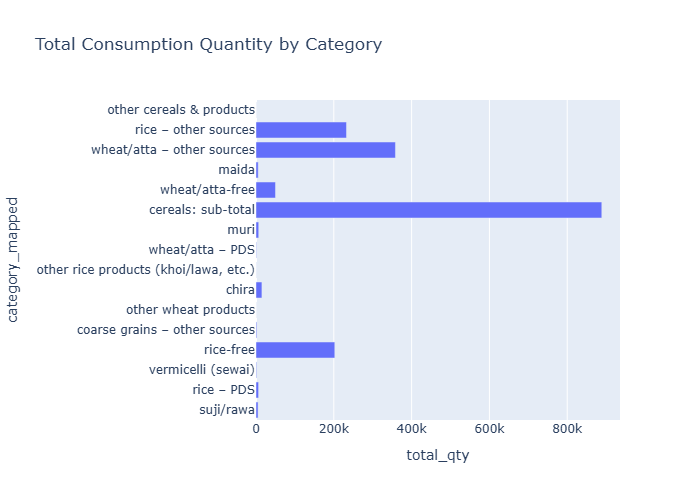

In [195]:
fig1 = total_consumption_qty_by_category()
fig1.show()

# Fun2

In [196]:
cat_df.columns

['category_mapped',
 'out_home_value',
 'out_home_qty',
 'total_qty',
 'total_value',
 'out_of_home_avg_pice',
 'total_avg_pice']

In [ ]:
def distribution_of_metric_by_categories(
    df = cat_df,
    cols = [
        "out_home_value","out_home_qty","out_of_home_avg_pice",
        "total_qty","total_value","total_avg_pice"
        ],
    title="Distribution of Metrics by Category"
):
    fig = make_subplots(
        rows=2,
        cols=3,
        subplot_titles=cols
    )

    positions = [
        (1, 1), (1, 2), (1, 3),
        (2, 1), (2, 2), (2, 3)
    ]

    for col, (r, c) in zip(cols, positions):
        fig.add_trace(
            go.Box(
                y=df[col],
                name=col,
                boxmean=True,
                hovertext=df["category_mapped"],

            ),
            row=r,
            col=c
        )

    fig.update_layout(
        title=title,
        showlegend=False,
        height=700
    )

    return fig

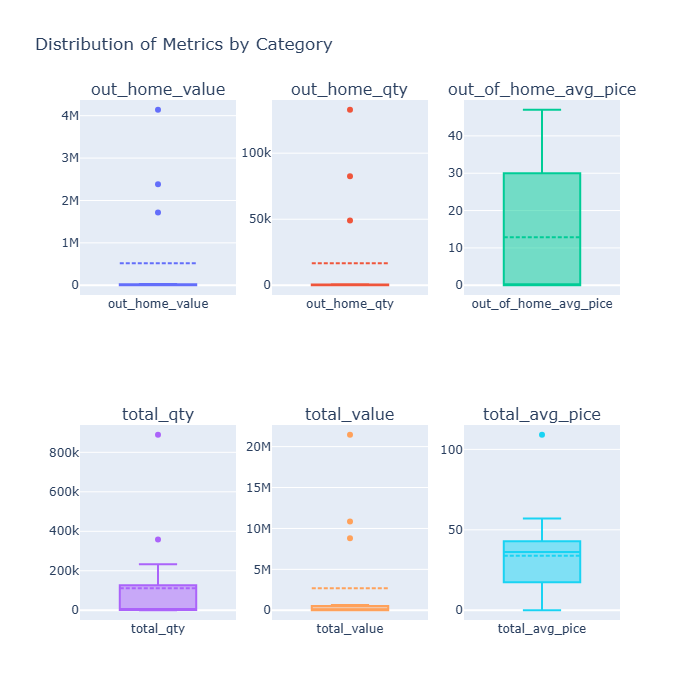

In [199]:
fig2 = distribution_of_metric_by_categories()
fig2.show()

# Fig 3

In [200]:
def total_qty_vs_total_value_by_category(df=cat_df):
    return px.scatter(
        df,
        x="total_qty",
        y="total_value",
        color="category_mapped",
        symbol="category_mapped",
        title="Total Quantity vs Total Value by Category",
        labels={
            "total_qty": "Total Quantity",
            "total_value": "Total Value"
        }
    )

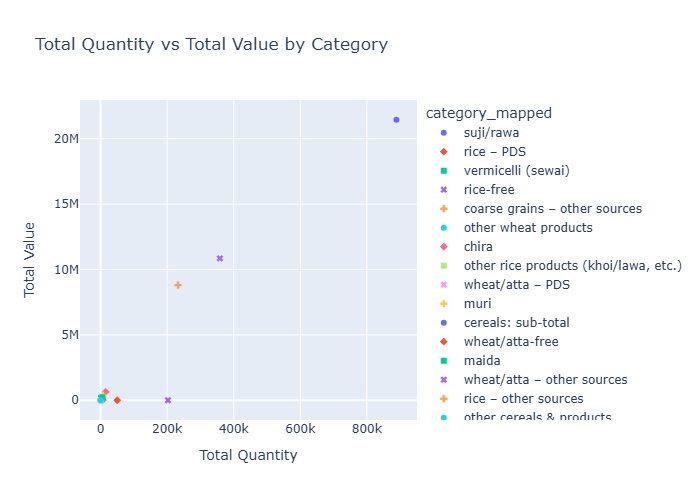

In [201]:
fig3 = total_qty_vs_total_value_by_category()
fig3.show()

In [202]:
def total_qty_vs_avg_price_by_category(df=cat_df):
    return px.scatter(
        df,
        x="total_qty",
        y="total_avg_pice",
        color="category_mapped",
        title="Total Quantity vs Average Price by Category"
    )

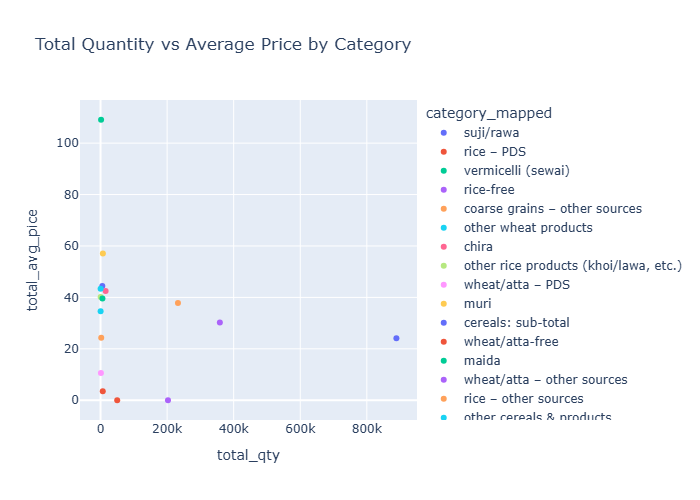

In [203]:
fig5 = total_qty_vs_avg_price_by_category()
fig5.show()

# Fig 4

In [204]:
def group_bar_chart_qty_type(df=cat_df):
    return df.select([
        "category_mapped",
        "out_home_qty",
        "total_qty"
    ]).unpivot(
        index="category_mapped",
        on=["out_home_qty", "total_qty"],
        variable_name="quantity_type",
        value_name="quantity"
    )

In [205]:
group_bar_chart_qty_type().to_pandas()

,category_mapped,quantity_type,quantity
0,suji/rawa,out_home_qty,0.000
1,rice – PDS,out_home_qty,0.000
2,vermicelli (sewai),out_home_qty,0.000
3,rice-free,out_home_qty,0.000
4,coarse grains – other sources,out_home_qty,607.500
5,other wheat products,out_home_qty,0.000
6,chira,out_home_qty,692.800
7,"other rice products (khoi/lawa, etc.)",out_home_qty,0.000
8,wheat/atta – PDS,out_home_qty,0.000
9,muri,out_home_qty,0.000


In [206]:
def out_of_home_vs_total_qty_by_category(qty_df=group_bar_chart_qty_type()):
    return px.bar(
        qty_df,
        x="category_mapped",
        y="quantity",
        color="quantity_type",
        barmode="group",
        title="Out-of-Home vs Total Quantity by Category"
    )

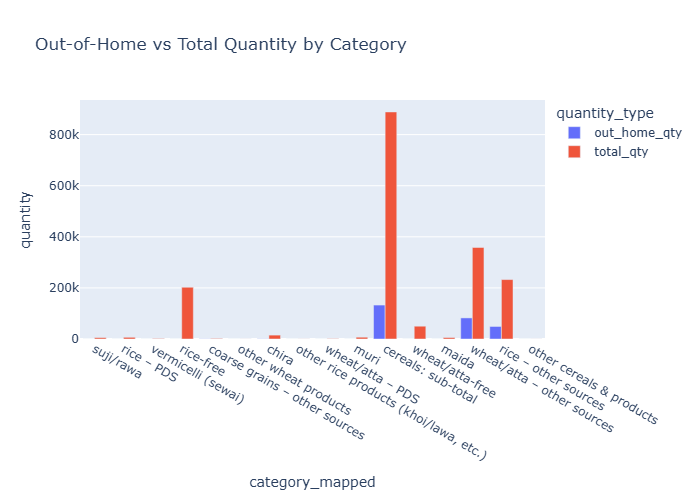

In [207]:
fig6 = out_of_home_vs_total_qty_by_category()
fig6.show()

# Fig 5

In [208]:
def stack_bar_chart_on_value(df=cat_df):
    return df.select([
        "category_mapped",
        "out_home_value",
        "total_value"
    ]).unpivot(
        index="category_mapped",
        on=["out_home_value", "total_value"],
        variable_name="value_type",
        value_name="value"
    )

In [209]:
stack_bar_chart_on_value().to_pandas()

,category_mapped,value_type,value
0,suji/rawa,out_home_value,0.0
1,rice – PDS,out_home_value,0.0
2,vermicelli (sewai),out_home_value,0.0
3,rice-free,out_home_value,0.0
4,coarse grains – other sources,out_home_value,13112.0
5,other wheat products,out_home_value,0.0
6,chira,out_home_value,29196.0
7,"other rice products (khoi/lawa, etc.)",out_home_value,0.0
8,wheat/atta – PDS,out_home_value,0.0
9,muri,out_home_value,0.0


In [210]:
def out_of_home_vs_total_value_stack_graph(val_df=stack_bar_chart_on_value()):
    return px.bar(
        val_df,
        x="category_mapped",
        y="value",
        color="value_type",
        barmode="stack",
        title="Out-of-Home vs Total Consumption Value"
    )

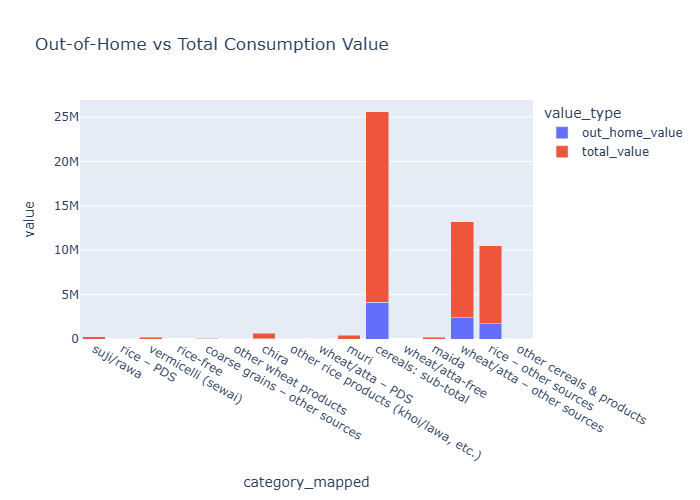

In [211]:
out_of_home_vs_total_value_stack_graph()

# Fig 6

In [212]:
def consumption_pattern_by_category(df =cat_df):
    return px.scatter(
        df,
        x="total_qty",
        y="total_value",
        size="total_avg_pice",
        color="category_mapped",
        title="Consumption Pattern by Category",
        size_max=40
    )

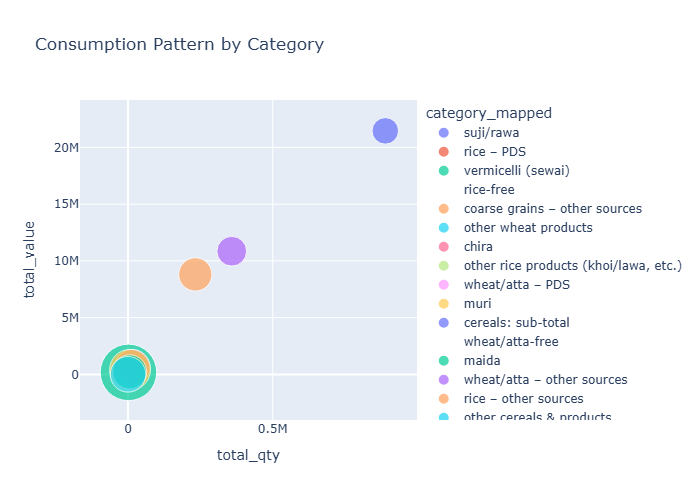

In [213]:
consumption_pattern_by_category()